# Tree Crown Detection

The delineation of individual trees in remote sensing images is an key task in forest analysis. As part of Sebastian Hickman's AI4ER MRes project, titled 'Detecting changes in tall tree height with machine learning, LiDAR, and RGB imagery', the authors propose the `detectreeRGB` model, an implementation of Mask R-CNN from [Detectron2](https://github.com/facebookresearch/detectron2) to perform tree crown delineation from RGB imagery.

<img src="https://github.com/shmh40/detectreeRGB/blob/main/imgs/plot_13_285520_583300.jpg?raw=true" width="400">

**Figure 1** Example image of the predictions made by Mask R-CNN. Source: [Hickman et al. (2021)](https://github.com/shmh40/detectreeRGB).

<div class="alert alert-block alert-info">
     <p>   
        In this notebook, we'll walk through how scivision can assist in discovering a pretrained detectreeRGB model provided by Hickman et al (2021), and then use it to delineate crowns from a sample drone RGB image dataset.
    </p> 
    <p>    
    Further details of the detectreeRGB can be found in 
        <a href="https://github.com/shmh40/detectreeRGB/"> the original model repository</a>.
    </p>     
</div>

## Load libraries

In [1]:
!pip install opencv-python-headless #hide only if the notebook runs in standard desktop environments

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 24.6 MB/s eta 0:00:0000:0100:01


In [4]:
from scivision.catalog import default_catalog
from scivision.io import load_dataset, load_pretrained_model
import pooch

## Catalog
We'll use the detectreeRGB model which is registered in the `scivision` model catalog as `detectreeRGB-forest`. Then we'll look with compatible_datasources potential data entries registered in the scivision data catalog with tasks and format compatible with the model.

In [5]:
model_name = 'detectreeRGB-forest'

In [6]:
compatible_datasources = default_catalog.compatible_datasources(model_name).to_dataframe()

This returns a `pandas.dataframe` with the number of potential datasets to pair the model with.

In [7]:
compatible_datasources

,name,description,url,tasks,labels_provided,domains,institution,tags
0,stardist-cell-nuclei-2D,Cell microscopy test dataset for detection and...,https://github.com/stardist/stardist/releases/...,"(TaskEnum.segmentation, TaskEnum.object_detect...",True,(optical-microscopy),"(epfl,)","(help-needed, 3D, cell, cell-counting, biology..."
1,oppd-seedlings,The Open Plant Phenotyping Database [OPPD] is ...,https://github.com/alan-turing-institute/oppd-...,"(TaskEnum.segmentation, TaskEnum.thresholding,...",True,"(multispectral, hyperspectral)","(Aarhus University,)","(help-needed, 2D, plant-phenotyping, agricultu..."
2,scivision-test-data,Test data comprised of individual images inclu...,https://github.com/alan-turing-institute/scivi...,"(TaskEnum.segmentation, TaskEnum.object_detect...",True,(computer-vision),"(Wikipedia by Erik Veland,)","(demo,)"
4,coastal-edges,Sample dataset of satellite RGB imagery over t...,https://github.com/MartinSJRogers/VEdge_Detect...,"(TaskEnum.segmentation, TaskEnum.classificiation)",False,"(ecology, computer-vision, earth-observation)","(Cambridge University,)","(2D, satellite, remote-sensing, ecology, envir..."
5,treecrowns,Sample dataset of drone RGB imagery over Sepil...,https://github.com/acocac/detectreeRGB-treecro...,"(TaskEnum.segmentation, TaskEnum.object_detect...",False,"(ecology, computer-vision, earth-observation)","(Cambridge University,)","(2D, drone, satellite, aerial, remote-sensing,..."
6,sentinel2_stac,Data plugin for accessing Sentinel-2 Cloud-Opt...,https://github.com/alan-turing-institute/scivi...,"(TaskEnum.segmentation, TaskEnum.classificiation)",False,"(ecology, computer-vision, earth-observation)","(The Alan Turing Institute,)","(satellite, aerial, remote-sensing, ecology, e..."
9,Parakeet,Synthetic cryoEM data from Parakeet,https://github.com/rosalindfranklininstitute/s...,"(TaskEnum.segmentation, TaskEnum.thresholding,...",False,None,"(Rosalind Franklin Institute,)","(CryoEM,)"
11,Phenotypic Profiling,Plate 20585 - Phenotypic profiling attempts to...,https://github.com/Tonks684/phenotypic_profili...,(TaskEnum.segmentation),False,(fluorescent microscopy),"(Broad Institute,)","(fluorescence microscopy , bioimaging)"
13,NPPC_B_napus,Top and side view RGB png images as analysed f...,https://raw.githubusercontent.com/alan-turing-...,"(TaskEnum.segmentation, TaskEnum.object_detect...",False,"(plant-biology, biology, agriculture, multispe...","(Aberystwyth University, National Plant Phenom...","(plant-phenotyping, 2D, agriculture, climate-c..."
14,NHM-pinned-insects,Sample of images of pinned insects and corresp...,https://raw.githubusercontent.com/LittleAri/Pi...,"(TaskEnum.segmentation, TaskEnum.other)",True,"(entomology, computer-vision)","(Natural History Museum,)","(museum-collections, ocr, pinned-insects, 2D)"


## Model
The following lines will look for the model URL (in this case the GitHub repository) from the scivision model catalog. After, the `load_pretrained_model` function will recognise the URL and install dependencies if they are not yet in the current virtual environment.

In [8]:
models = default_catalog.models.to_dataframe()
targetmodel = models[models.name == model_name].url.item()
model = load_pretrained_model(targetmodel, allow_install=True)

  Cloning https://github.com/acocac/detectreeRGB-treecrown-scivision (to revision main) to /tmp/pip-install-4s0xw8ad/detectreergb-treecrown-scivision_37a96643f24e40898d89ea83ef68370e


  Running command git clone --filter=blob:none --quiet https://github.com/acocac/detectreeRGB-treecrown-scivision /tmp/pip-install-4s0xw8ad/detectreergb-treecrown-scivision_37a96643f24e40898d89ea83ef68370e


  Resolved https://github.com/acocac/detectreeRGB-treecrown-scivision to commit a5b881f9b128ad9eef2fb479df6c05f4872eea59
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.6) to /tmp/pip-install-4s0xw8ad/detectron2_9ee1a3547a4b421c99d93bb3d8934cc4


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-4s0xw8ad/detectron2_9ee1a3547a4b421c99d93bb3d8934cc4
  Running command git checkout -q d1e04565d3bec8719335b88be9e9b961bf3ec464


  Resolved https://github.com/facebookresearch/detectron2.git to commit d1e04565d3bec8719335b88be9e9b961bf3ec464
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 34.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 27.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 39.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.9/220.9 kB 21.1 MB/s eta 0:00:00
  Created wheel for detectreeRGB_treecrown_scivision: filename=detectreeRGB_treecrown_scivision-0.0.1-py3-none-any.whl size=3956 sha256=a3dd2bed87ac21cb65bc58f52530ca4b96274bfd294cd0a1ab45836c03362aea
  Stored in directory: /tmp/pip-ephem-wheel-cache-kcqhrmih/wheels/

In [9]:
model

scivision.PretrainedModel( 
  module='detectreeRGB_treecrown_scivision', 
  model='DetectreeRGB', 
  source='https://github.com/acocac/detectreeRGB-treecrown-scivision' 
  pipe='DataPipe(input=<Parameter "X: numpy.ndarray">, output=<Parameter "image: numpy.ndarray">)' 
)

## Data

We'll load one of the suggested datasets in compatible_datasources. In this case, we will use the dataset registered with the name field equals to `treecrowns`. This refers to a drone image dataset kindly shared by Hickman et al. in a [zenodo repository](https://zenodo.org/record/5090039#.Ys_rxC8w1pQ) to demonstrate the `detectreeRGB` model.

In [10]:
target_datasource = compatible_datasources.loc[compatible_datasources['name'] == 'treecrowns']
target_datasource

,name,description,url,tasks,labels_provided,domains,institution,tags
5,treecrowns,Sample dataset of drone RGB imagery over Sepil...,https://github.com/acocac/detectreeRGB-treecro...,"(TaskEnum.segmentation, TaskEnum.object_detect...",False,"(ecology, computer-vision, earth-observation)","(Cambridge University,)","(2D, drone, satellite, aerial, remote-sensing,..."


We use `pooch` to fetch the file from the Zenodo repository.

In [11]:
file_path = pooch.retrieve(
    url="doi:10.5281/zenodo.5494629/Sep_2014_RGB_602500_646600.tif",
    known_hash="md5:77a3b57f5f5946504ec520d1e793f250",
    path='.',
    fname='Sep_2014_RGB_602500_646600.tif'
)

Then we use `load_dataset` from `scivision.io`. This will return a `intake.catalog.local.YAMLFileCatalog` with the information of the dataset.

In [12]:
cat = load_dataset(target_datasource.url.item())
dataset = cat.sepilok_rgb().to_dask()

In dataset, the sample image, which actually has an RGB bands plus additional band, is loaded into single `xarray.Dataset` object with a defined dimension, in this case 1400 px x 1400 px. 

In [13]:
dataset

<xarray.DataArray (band: 4, y: 1400, x: 1400)>
array([[[36166.285 , 34107.22  , ..., 20260.998 , 11166.631 ],
        [32514.84  , 28165.994 , ..., 24376.36  , 21131.947 ],
        ...,
        [15429.493 , 16034.794 , ..., 19893.691 , 19647.646 ],
        [12534.722 , 14003.215 , ..., 21438.908 , 22092.525 ]],

       [[38177.168 , 36530.74  , ..., 19060.268 , 11169.006 ],
        [34625.227 , 30270.379 , ..., 21760.09  , 20796.621 ],
        ...,
        [17757.678 , 16818.102 , ..., 22538.023 , 23093.508 ],
        [13403.302 , 13354.489 , ..., 24638.21  , 25545.938 ]],

       [[13849.501 , 14158.603 , ...,  9385.764 ,  7401.662 ],
        [13252.31  , 13373.801 , ..., 12217.845 , 10666.252 ],
        ...,
        [13471.741 , 11533.697 , ...,  7536.6924,  8397.009 ],
        [13724.59  , 11057.722 , ...,  9778.8125, 11174.72  ]],

       [[65535.    , 65535.    , ..., 65535.    , 65535.    ],
        [65535.    , 65535.    , ..., 65535.    , 65535.    ],
        ...,
        [65535.    , 65535.    , ..., 65535.    , 65535.    ],
        [65535.    , 65535.    , ..., 65535.    , 65535.    ]]], dtype=float32)
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 6.025e+05 6.025e+05 ... 6.026e+05 6.026e+05
  * y            (y) float64 6.467e+05 6.467e+05 ... 6.466e+05 6.466e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  64207.40625
    STATISTICS_MEAN:     19686.638496859
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   8437.6015029148
    _FillValue:          -3.4e+38
    scale_factor:        1.0
    add_offset:          0.0

## Prediction and visualisation
Once we load model and data, we will use the predict function previously defined within the scivision configuration file of the model. In this example, the predict function goes over the RGB bands of the image and we enable the `plot` argument to plot the predictions over the drone RGB image. If we set `plot=False`, it will only return the instance values which can be then plotted as it is indicated in the example of detectreeRGB in the Environmental Data Science book (see [here](https://the-environmental-ds-book.netlify.app/gallery/modelling/forest-modelling-treecrown_detectreergb/forest-modelling-treecrown_detectreergb#showing-the-predictions-from-detectreergb)).

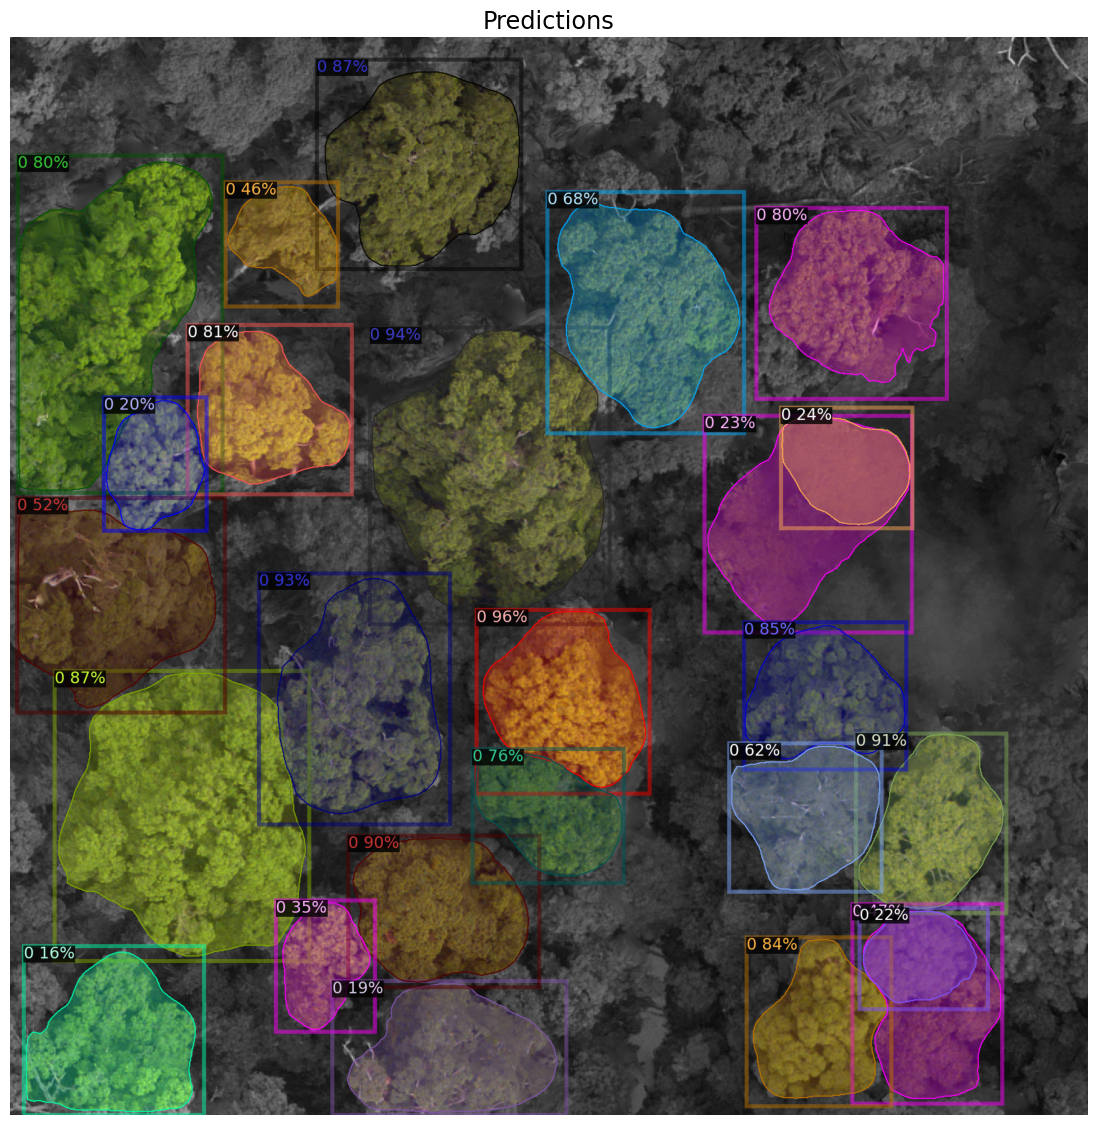

In [14]:
y = model.predict(dataset.sel(band=slice(1,3)), plot=True)